# Evaluation for Kirk Experiment

In [5]:
import sys
from omegaconf import OmegaConf, DictConfig
from typing import Union, Dict, Optional
from pathlib import Path
from experiments.evaluation.utils import recover_traincfg_from_wandb

sys.path.append("../..")
folder_train = "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/exp_sweep/2022-07-01/14-14-50_benchmark_train/"
folder_eval = (
    "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2022-07-06/17-21-44"
)
folder_eval = "/home/benjamin/Dokumente/code/tmp/CARL/multirun/2022-07-07/07-57-17/"




In [10]:
from rich import print as printr
from rich.progress import track
import pickle
from pathlib import Path
import numpy as np
import ast
import pandas as pd
from tqdm import tqdm
from wandb.sdk.wandb_helper import parse_config
from experiments.common.utils.json_utils import lazy_json_load
from experiments.evaluation.run_evaluation import find_multirun_paths


def load_wandb_table(fn: Union[str, Path]) -> pd.DataFrame:
    data = lazy_json_load(fn)
    data = pd.DataFrame(data=np.array(data["data"]), columns=data["columns"])
    return data


reload_rpc: bool = False

fn_config = ".hydra/config.yaml"
fn_wbsummary = "wandb/latest-run/files/wandb-summary.json"
fn_wbconfig = "wandb/latest-run/files/config.yaml"
rpc_fn = Path("rpc.csv")
if not rpc_fn.is_file():
    reload_rpc = True

paths = find_multirun_paths(result_dir=folder_eval)

if reload_rpc:
    rpc_list = []
    for i, p in tqdm(enumerate(paths)):
        p = Path(p)
        fn_cfg = p / fn_config
        fn_wbsum = p / fn_wbsummary
        fn_wbcfg = p / fn_wbconfig
        if not fn_wbcfg.is_file() or not fn_wbsum.is_file() or not fn_cfg.is_file():
            continue
        cfg = OmegaConf.load(fn_cfg)
        traincfg = recover_traincfg_from_wandb(fn_wbcfg)
        summary = lazy_json_load(fn_wbsum)

        if traincfg is not None:
            mode = traincfg.kirk_evaluation_protocol.mode
        else:
            mode = cfg.kirk_evaluation_protocol.mode
        if "average_return" in summary:
            average_return = summary["average_return"]
        else:
            average_return = None

        if mode is None or average_return is None:
            continue

        distribution_type = cfg.kirk_evaluation_protocol.distribution_type
        entry = {
            "mode": mode,
            "distribution_type": distribution_type,
            "average_return": average_return,
        }


        path_to_table = fn_wbsum.parent / summary["return_per_context_table"]["path"]
        return_per_context = load_wandb_table(path_to_table)

        contexts_path = fn_wbsum.parent / summary["evalpost/contexts"]["path"]
        contexts = load_wandb_table(contexts_path)

        visibility = traincfg.wandb.group

        context_ids = return_per_context["context_id"].apply(int).to_list()
        contexts_to_table = pd.DataFrame([contexts.iloc[cidx] for cidx in context_ids])
        for col in contexts_to_table.columns:
            return_per_context[col] = contexts_to_table[col].to_numpy()
        n = len(return_per_context)
        return_per_context["mode"] = [mode] * n
        return_per_context["distribution_type"] = [distribution_type] * n
        return_per_context["average_return"] = [average_return] * n
        return_per_context["visibility"] = visibility
        rpc_list.append(return_per_context)

        # if i == 10:
        #     break

if reload_rpc:
    df_rpc = pd.concat(rpc_list)
    df_rpc.to_csv(rpc_fn)
else:
    df_rpc = pd.read_csv(rpc_fn)

In [3]:
# Plotting definitions
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

vmin = 350  # df_rpc["return"].min()
vmax = 500  # df_rpc["return"].max()
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

In [ ]:
grid = sns.FacetGrid(df, col="mode", height=6)
grid.map(sns.barplot, "distribution_type", "average_return")

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

xlabel = "gravity"
ylabel = "pole_length"
figsize = (8, 6)
dpi = 200
# grid = sns.FacetGrid(df_rpc, col="mode", height=6, hue="distribution_type")
# grid.map(sns.scatterplot, xlabel, ylabel, style="return")

# for i, (mode, ax) in enumerate(grid.axes_dict.items()):
#     print(i)
# print(list(grid.facet_data()))

group_key = "mode"
groups = df_rpc.groupby(group_key)
n_groups = len(groups)
fig = plt.figure(figsize=figsize, dpi=dpi)
axes = fig.subplots(nrows=1, ncols=n_groups, sharex=True, sharey=True)
cmap = "viridis"
for i, (group_id, df) in enumerate(groups):
    print(i, group_id)
    ax = axes[i]
    ax.scatter(
        x=df[xlabel], y=df[ylabel], c=df["average_return"], s=1, norm=norm, cmap=cmap
    )
    ax.set_box_aspect(1)

    # break
    if i == n_groups - 1:
        fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
fig.set_tight_layout(True)

plt.show()

## Plot Evaluation Protocol Modes

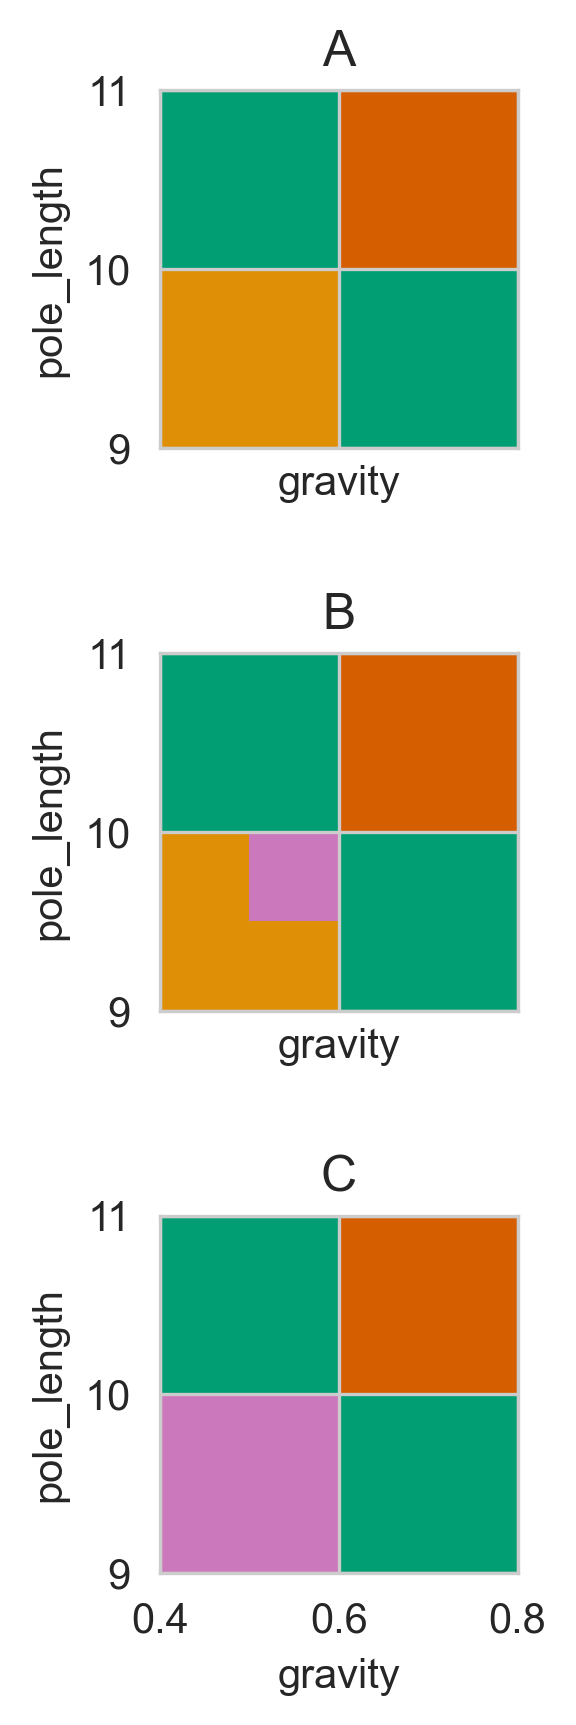

In [13]:
from hydra.utils import instantiate
from experiments.evaluation_protocol.plot_evaluate_on_protocol import get_ep_mplpatches
from experiments.evaluation_protocol.plot_traintest_distributions import get_legend_elements

traincfg = recover_traincfg_from_wandb(Path(folder_eval) / "0" / fn_wbconfig)
context_features = [
    instantiate(config=cf) for cf in traincfg.kirk_evaluation_protocol.context_features
][::-1]

modes = r"ABC"

fig = plt.figure(figsize=(2, 6), dpi=300)
axes = fig.subplots(nrows=len(modes), ncols=1, sharex=True, sharey=True)
for i, mode in enumerate(modes):
    ax = axes[i]
    patches = get_ep_mplpatches(
            context_features=context_features,
            draw_frame=False,
            mode=mode,
            patch_kwargs=dict(linewidth=0),
        )
    for patch in patches:
        ax.add_patch(patch)
    ax.set_box_aspect(1)

    cf0, cf1 = context_features

    # Set ax lims
    xlim = (cf0.lower, cf0.upper)
    ylim = (cf1.lower, cf1.upper)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)

    # Add axis descriptions
    ax.set_ylabel(cf0.name)
    if i == len(modes) - 1:
        ax.set_xlabel(cf1.name)
    ax.set_title(mode)
    yticks = [cf1.lower, cf1.mid, cf1.upper]
    ax.set_yticks(yticks)

# Add legend
# legend_elements = get_legend_elements()

fig.set_tight_layout(True)
fig_fn = Path("./data/kirk_distribution_regions.png")
fig_fn.parent.mkdir(exist_ok=True, parents=True)
fig.savefig(fig_fn, dpi=300, bbox_inches="tight")
plt.show()

# Plot Heatmaps
  (0, 0) origin       9     gravity     11
    X------------------->
    |  0.6
    |
    |
    |  pole_length
    |
    |
    |
    V  0.4

(3, 3)
467.42783323629584 18.1381724461579
470.41775381572245 18.47935613068475
466.51949007541623 16.22490825178415
491.0486575938181 9.441200230963197
469.43219719141206 18.61113813476025
480.60424490363033 14.787412110474872
476.57011289958865 14.66345983554654
480.8410997007542 13.134978678424547
477.8511568468748 11.415339785702495


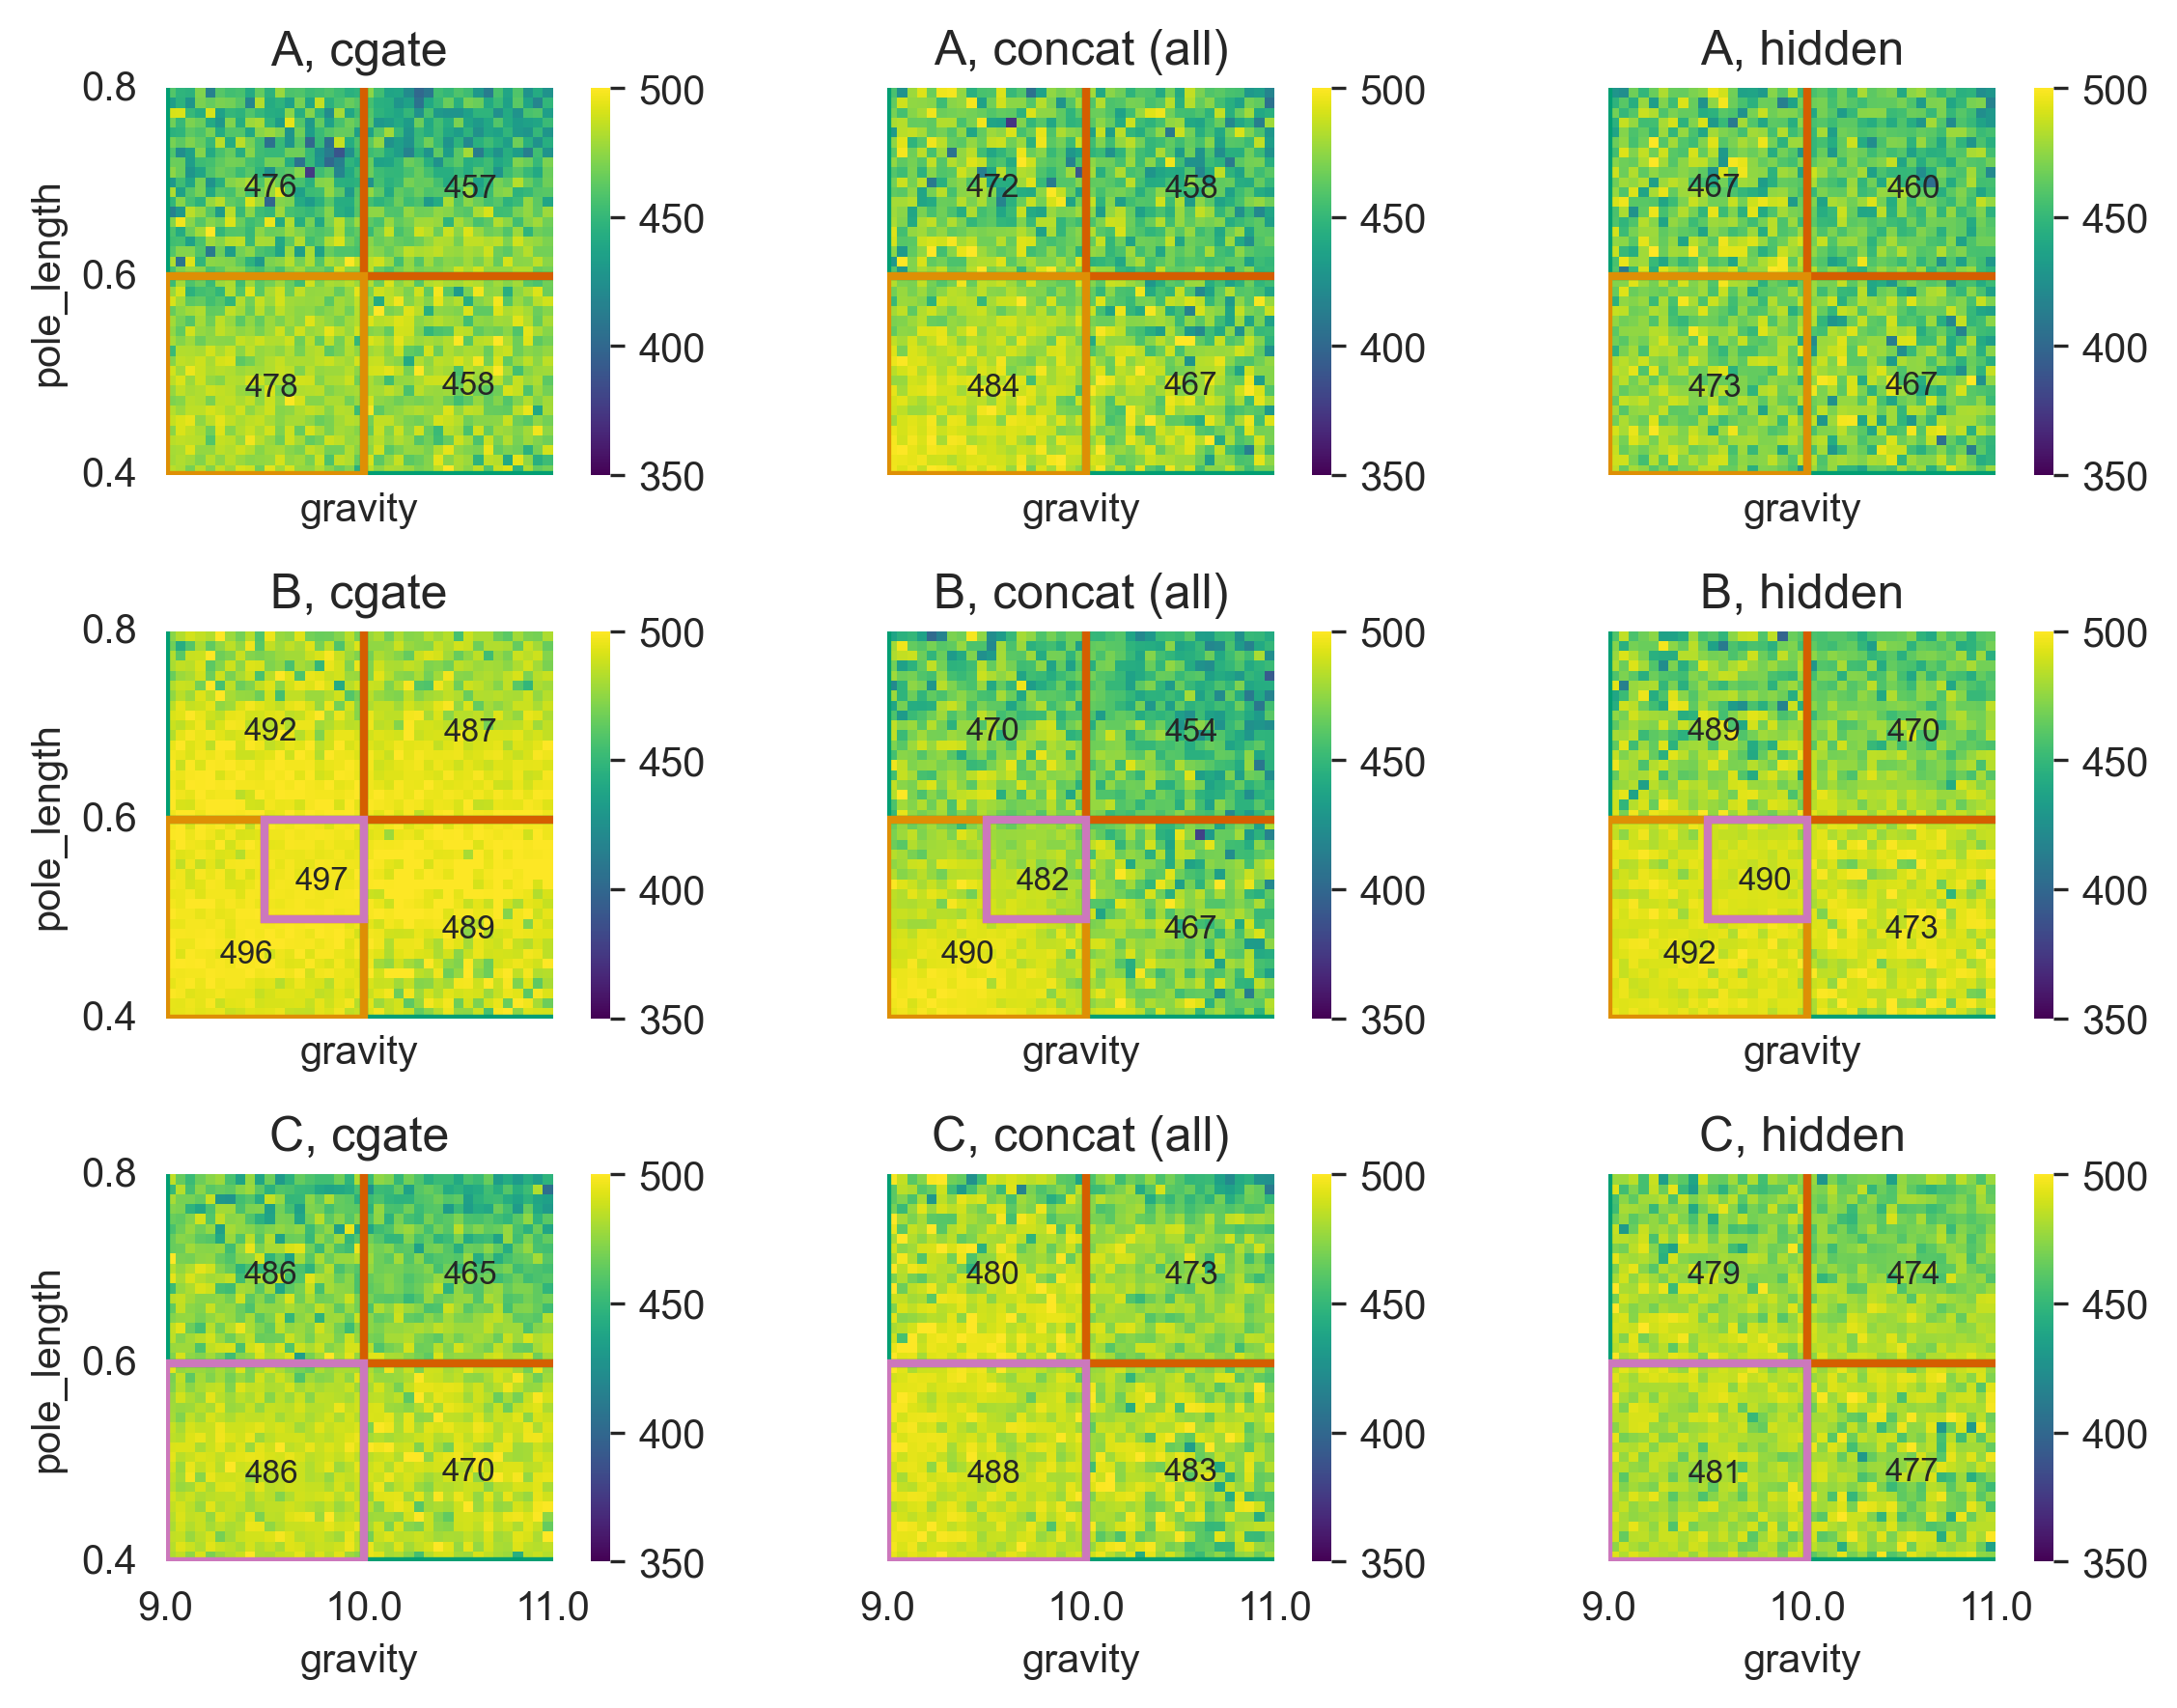

In [45]:
from copy import copy
from hydra.utils import instantiate
from experiments.evaluation_protocol.plot_evaluate_on_protocol import get_ep_mplpatches

traincfg = recover_traincfg_from_wandb(Path(folder_eval) / "0" / fn_wbconfig)

plt.rcParams["axes.grid"] = False

always_add_xlabel = True
add_numbers_on_heatmap = True
annot_with_std = False

df = df_rpc
n_bins = 40
discretizer = {
    "pole_length": (0.4, 0.8, n_bins),  # rows of heatmap
    "gravity": (9, 11, n_bins),  # cols of heatmap
}
filter_distribution_types = [
    "train",
    # "test_interpolation",
    # "test_interpolation_combinatorial",
    # "test_extrapolation_single",
    # "test_extrapolation_all"
]
for fil in filter_distribution_types:
    df = df[df["distribution_type"] != fil]

context_features = [
    instantiate(config=cf) for cf in traincfg.kirk_evaluation_protocol.context_features
]
context_features_bins = []
for cf in context_features:
    cf = copy(cf)

    def transform(v: float) -> float:
        return (v - cf.lower) / (cf.upper - cf.lower) * n_bins

    vals_to_discretize = [cf.lower, cf.lower_constraint, cf.mid, cf.upper]
    transformed = [transform(v) for v in vals_to_discretize]
    cf.lower, cf.lower_constraint, cf.mid, cf.upper = transformed
    context_features_bins.append(cf)

cmap = copy(plt.cm.viridis)
cmap.set_bad(color="k")

group_keys = ["mode", "visibility"]  # , "distribution_type"]
groups = df.groupby(group_keys)
fig = plt.figure(figsize=(8, 6), dpi=300)
axes = fig.subplots(nrows=df[group_keys[0]].nunique(), ncols=df[group_keys[1]].nunique(), sharex=True, sharey=True)
print(axes.shape)
for i, (group_id, group_df) in enumerate(groups):
    ax = axes.flatten()[i]
    mode = group_id[group_keys.index("mode")]
    for key, args in discretizer.items():
        bins = np.linspace(*args)
        ids = np.digitize(group_df[key].to_numpy(), bins=bins) - 1
        discretized = [bins[i] for i in ids]
        group_df[key + "_discrete"] = discretized
        group_df[key + "_id"] = ids

    # reduce dataframe by average over same contexts
    reduced = group_df.groupby([k + "_id" for k in discretizer.keys()]).mean()
    heatmap = np.zeros((n_bins - 1, n_bins - 1))

    for idx in reduced.index:
        row = reduced.loc[idx]
        ret = row["return"]
        heatmap[idx] = ret

    hm_mean = np.mean(heatmap[heatmap != 0])
    hm_std = np.std(heatmap[heatmap != 0])
    print(hm_mean, hm_std)

    heatmap[heatmap == 0] = np.nan

    patches = get_ep_mplpatches(
        context_features=context_features_bins,
        draw_frame=True,
        mode=mode,
        patch_kwargs=dict(linewidth=2),
    )

    ax = sns.heatmap(heatmap, ax=ax, cmap=cmap, norm=norm)
    ax.set_box_aspect(1)
    ax.invert_yaxis()

    # ticks
    cf0, cf1 = context_features_bins
    xticks = [cf0.lower, cf0.mid, cf0.upper - 1]
    yticks = [cf1.lower, cf1.mid, cf1.upper - 1]
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)

    cf0, cf1 = context_features
    xticklabels = [cf0.lower, cf0.mid, cf0.upper]
    yticklabels = [cf1.lower, cf1.mid, cf1.upper]
    ax.set_xticklabels(xticklabels, rotation=0)
    ax.set_yticklabels(yticklabels, rotation=0)

    # Add numbers onto region
    if add_numbers_on_heatmap:
        distr_types = [
            "test_interpolation",
            "test_interpolation_combinatorial",
            "test_extrapolation_single",
            "test_extrapolation_all"
        ]
        subgroups = group_df.groupby("distribution_type")
        for j, (subgroup_id, subgroup_df) in enumerate(subgroups):
            xid = list(discretizer.keys())[0]
            xv = discretizer[xid]
            yid = list(discretizer.keys())[1]
            yv = discretizer[yid]

            def annotate(df):
                region_mean = df["return"].mean()
                region_std = df["return"].std()
                text = f"{region_mean:.0f}"
                if annot_with_std:
                    text += f"±{region_std:.0f}"

                x = df[xid].mean()
                y = df[yid].mean()

                def map_to_pixels(x, l, u, n_bins):
                    return (x - l) / (u - l) * n_bins

                n_bins = len(bins)
                x = map_to_pixels(x, xv[0], xv[1], n_bins)
                y = map_to_pixels(y, yv[0], yv[1], n_bins)

                x_offset = -2
                if annot_with_std:
                    x_offset -= 2
                ax.text(x=x+x_offset, y=y-2, s=text, fontsize=8)
                return text

            if subgroup_id == "test_extrapolation_single":
                mid = (xv[1] + xv[0]) / 2
                df = subgroup_df[subgroup_df[xid] < mid]
                text = annotate(df)
                text = annotate(subgroup_df[subgroup_df[xid] > mid])
            else:
                text = annotate(subgroup_df)

    # Add ylabel to first column
    if i % axes.shape[0] == 0:
        ax.set_ylabel(list(discretizer.keys())[0])

    # Add xlabel to last row
    if i >= np.prod(axes.shape) - axes.shape[1] or always_add_xlabel:
        ax.set_xlabel(list(discretizer.keys())[1])

    # # Remove colorbars except for last column
    # if (i + 1) % axes.shape[0] == 0:
    #     from rich import inspect
    #     inspect(ax)

    # ax.axis("off")
    for patch in patches:
        ax.add_patch(patch)
    ax.set_title(", ".join(group_id))

fig.set_tight_layout(True)
fig_fn = Path("./data/kirk_heatmaps.png")
fig_fn.parent.mkdir(exist_ok=True, parents=True)
fig.savefig(fig_fn, bbox_inches="tight")
plt.show()

In [ ]:
# need defs from cell before
# grid = sns.FacetGrid(df, col="mode", height=4)
# grid.map(sns.barplot, "visibility", "return", color='cornflowerblue')
# for rows in grid.axes:
#     for ax in rows:
#         ax.set_ylim(440, vmax)

ax = sns.barplot(data=df, x="mode", y="return", hue="visibility", palette="colorblind")
ax.set_ylim(440, vmax)

/home/benjamin/.conda/envs/py39/lib/python3.9/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/benjamin/.conda/envs/py39/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/benjamin/.conda/envs/py39/lib/python3.9/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/benjamin/.conda/envs/py39/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/benjamin/.conda/envs/py39/lib/python3.9/site-packages/seaborn/categorical.py:381: DeprecationWarning: 

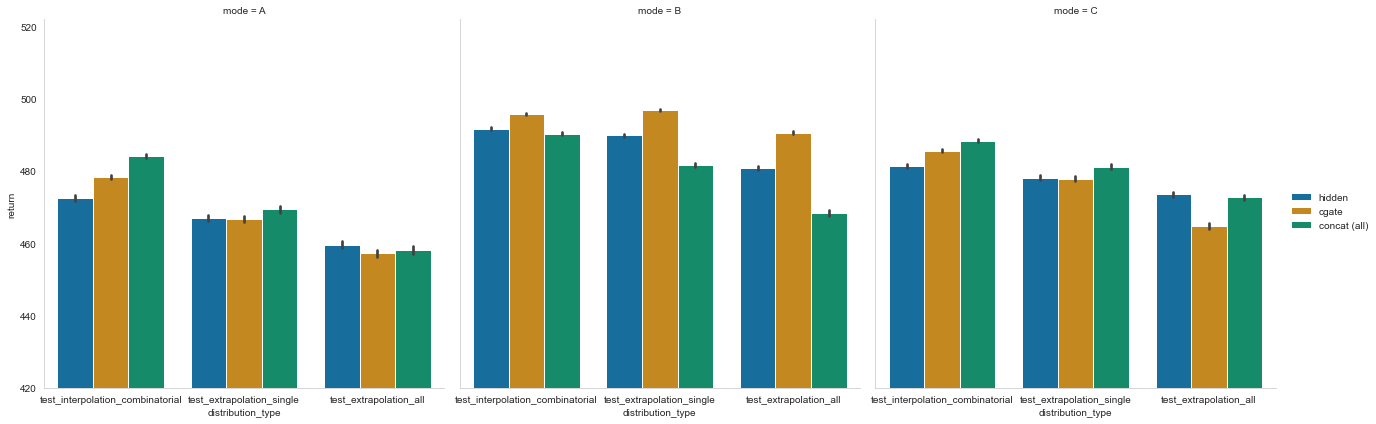

In [27]:
grid = sns.FacetGrid(df, col="mode", height=6, legend_out=True)
grid.map_dataframe(sns.barplot, x="distribution_type", y="return", hue="visibility", palette="colorblind")
grid.set(ylim=(420, None))
grid.add_legend()

0 A
1 B
2 C


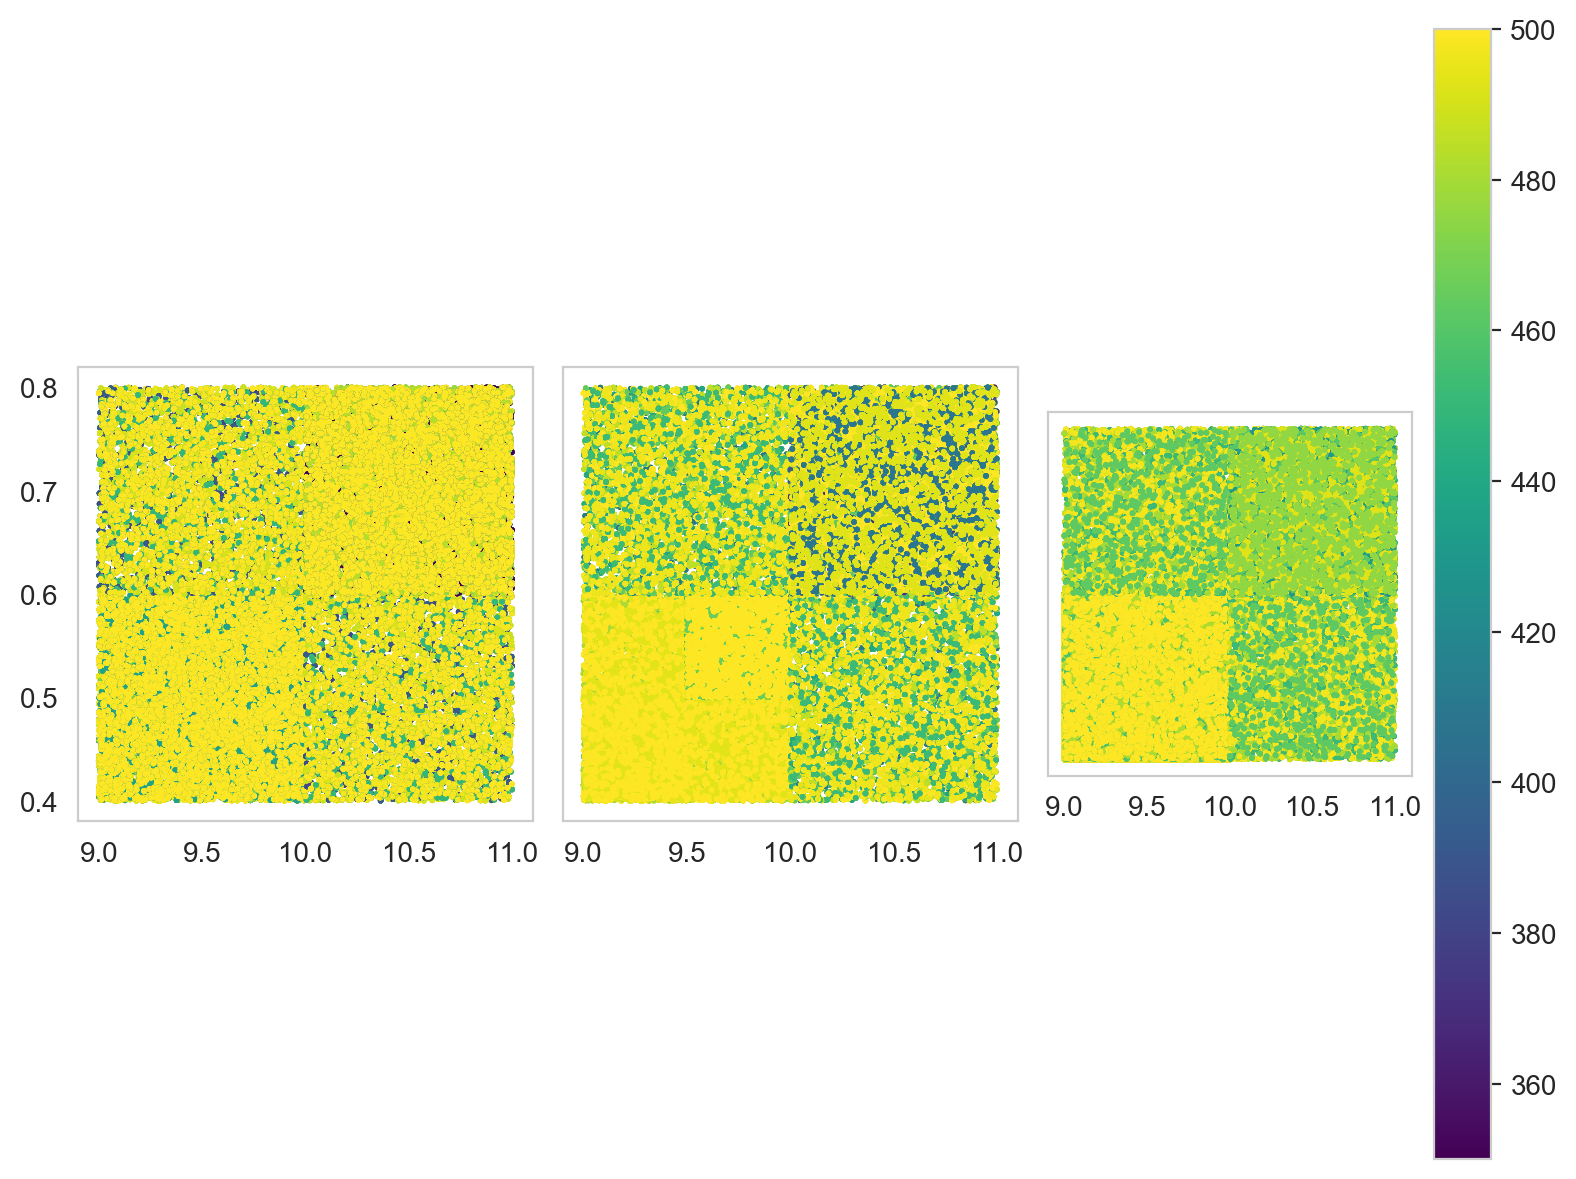

In [15]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

xlabel = "gravity"
ylabel = "pole_length"
figsize = (8, 6)
dpi = 200
# grid = sns.FacetGrid(df_rpc, col="mode", height=6, hue="distribution_type")
# grid.map(sns.scatterplot, xlabel, ylabel, style="return")

# for i, (mode, ax) in enumerate(grid.axes_dict.items()):
#     print(i)
# print(list(grid.facet_data()))

group_key = "mode"
groups = df_rpc.groupby(group_key)
n_groups = len(groups)
fig = plt.figure(figsize=figsize, dpi=dpi)
axes = fig.subplots(nrows=1, ncols=n_groups, sharex=True, sharey=True)
cmap = "viridis"
for i, (group_id, df) in enumerate(groups):
    print(i, group_id)
    ax = axes[i]
    ax.scatter(
        x=df[xlabel], y=df[ylabel], c=df["average_return"], s=1, norm=norm, cmap=cmap
    )
    ax.set_box_aspect(1)

    # break
    if i == n_groups - 1:
        fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
fig.set_tight_layout(True)

plt.show()

# Plot Heatmaps
  (0, 0) origin       9     gravity     11
    X------------------->
    |  0.6
    |
    |
    |  pole_length
    |
    |
    |
    V  0.4

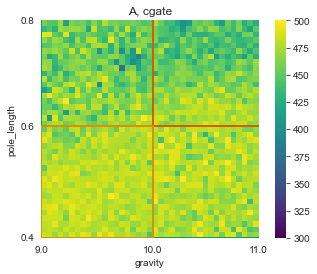

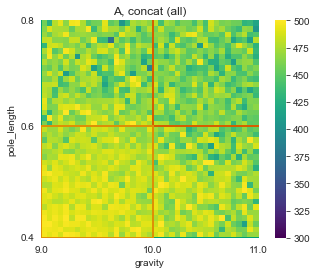

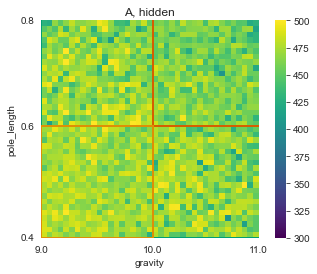

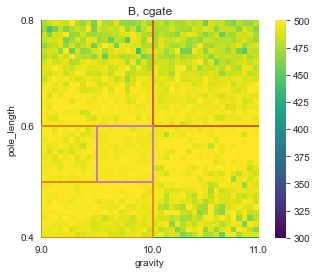

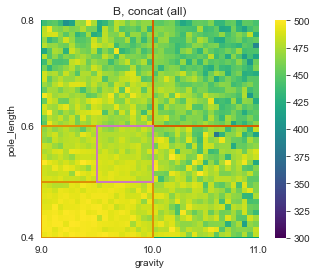

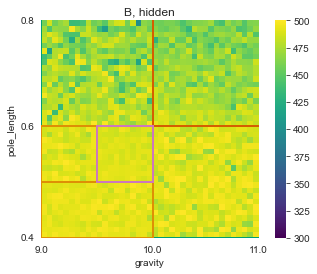

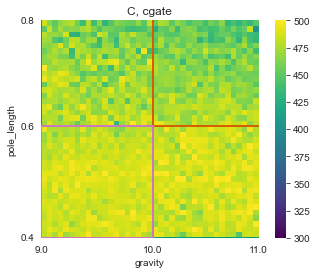

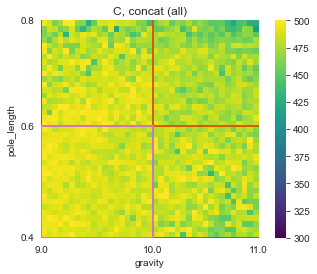

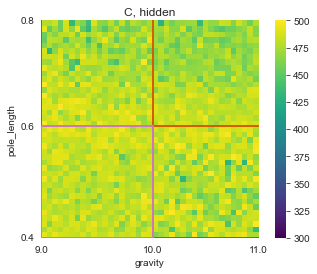

In [48]:
from copy import copy
from hydra.utils import instantiate
from experiments.evaluation_protocol.plot_evaluate_on_protocol import get_ep_mplpatches

traincfg = recover_traincfg_from_wandb(p.parent / "0" / fn_wbconfig)

plt.rcParams["axes.grid"] = False

df = df_rpc
n_bins = 40
discretizer = {
    "pole_length": (0.4, 0.8, n_bins),  # rows of heatmap
    "gravity": (9, 11, n_bins),  # cols of heatmap
}
filter_distribution_types = [
    "train",
    # "test_interpolation",
    # "test_interpolation_combinatorial",
    # "test_extrapolation_single",
    # "test_extrapolation_all"
]
for fil in filter_distribution_types:
    df = df[df["distribution_type"] != fil]

context_features = [
    instantiate(config=cf) for cf in traincfg.kirk_evaluation_protocol.context_features
]
context_features_bins = []
for cf in context_features:
    cf = copy(cf)

    def transform(v: float) -> float:
        return (v - cf.lower) / (cf.upper - cf.lower) * n_bins

    vals_to_discretize = [cf.lower, cf.lower_constraint, cf.mid, cf.upper]
    transformed = [transform(v) for v in vals_to_discretize]
    cf.lower, cf.lower_constraint, cf.mid, cf.upper = transformed
    context_features_bins.append(cf)

cmap = copy(plt.cm.viridis)
cmap.set_bad(color="k")

group_keys = ["mode", "visibility"]  # , "distribution_type"]
groups = df.groupby(group_keys)
for group_id, group_df in groups:
    mode = group_id[group_keys.index("mode")]
    for key, args in discretizer.items():
        bins = np.linspace(*args)
        ids = np.digitize(group_df[key].to_numpy(), bins=bins) - 1
        discretized = [bins[i] for i in ids]
        group_df[key + "_discrete"] = discretized
        group_df[key + "_id"] = ids

    # reduce dataframe by average over same contexts
    reduced = group_df.groupby([k + "_id" for k in discretizer.keys()]).mean()
    heatmap = np.zeros((n_bins - 1, n_bins - 1))

    for idx in reduced.index:
        row = reduced.loc[idx]
        ret = row["return"]
        heatmap[idx] = ret

    heatmap[heatmap == 0] = np.nan

    patches = get_ep_mplpatches(
        context_features=context_features_bins,
        draw_frame=True,
        mode=mode,
        patch_kwargs=dict(linewidth=2),
    )

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax = sns.heatmap(heatmap, ax=ax, cmap=cmap, norm=norm)
    ax.set_box_aspect(1)
    ax.invert_yaxis()

    # ticks
    cf0, cf1 = context_features_bins
    xticks = [cf0.lower, cf0.mid, cf0.upper - 1]
    yticks = [cf1.lower, cf1.mid, cf1.upper - 1]
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)

    cf0, cf1 = context_features
    xticklabels = [cf0.lower, cf0.mid, cf0.upper]
    yticklabels = [cf1.lower, cf1.mid, cf1.upper]
    ax.set_xticklabels(xticklabels, rotation=0)
    ax.set_yticklabels(yticklabels, rotation=0)

    ax.set_ylabel(list(discretizer.keys())[0])
    ax.set_xlabel(list(discretizer.keys())[1])

    # ax.axis("off")
    for patch in patches:
        ax.add_patch(patch)
    ax.set_title(", ".join(group_id))
    plt.show()

In [54]:
import wandb
from rich import inspect

context_features = r"abcdefg"
context_ids = r"CDEBA"
contexts = {i: {k: np.random.random() for k in context_features} for i in context_ids}
contexts_frame = pd.DataFrame(data=contexts).T
printr(contexts_frame)

table = wandb.Table(dataframe=contexts_frame)
inspect(table)

a         b         c         d         e         f         g
C  0.438486  0.447386  0.092220  0.567500  0.212121  0.300488  0.285370
D  0.784863  0.297124  0.011782  0.031282  0.356776  0.334310  0.347264
E  0.325587  0.842629  0.510174  0.694286  0.211346  0.178960  0.446832
B  0.534629  0.580528  0.755202  0.715649  0.150499  0.750171  0.797132
A  0.463361  0.601407  0.839739  0.693709  0.015679  0.617699  0.967425

╭────────────── <class 'wandb.data_types.Table'> ──────────────╮
│ The Table class is used to display and analyze tabular data. │
│                                                              │
│ ╭──────────────────────────────────────────────────────────╮ │
│ │ <wandb.data_types.Table object at 0x7f22d70594c0>        │ │
│ ╰──────────────────────────────────────────────────────────╯ │
│                                                              │
│           columns = ['a', 'b', 'c', 'd', 'e', 'f', 'g']      │
│              data = [                                        │
│                         [                                    │
│                             0.43848638237865134,             │
│                             0.4473858335463836,              │
│                             0.092220292312026,               │
│                             0.567500031392553,               │
│                             0.21212120726180161,             │
│                             0.3004880831885174,              │
│                             0.28536957762567516              │
│                         ],                                   │
│                         [                                    │
│                             0.7848633359066547,              │
│                             0.29712411553648177,             │
│                             0.011782068972146398,            │
│                             0.031282243872074234,            │
│                             0.35677608326584775,             │
│                             0.3343097291266548,              │
│                             0.34726365819952776              │
│                         ],                                   │
│                         [                                    │
│                             0.3255867078933272,              │
│                             0.8426291454624986,              │
│                             0.5101737338039276,              │
│                             0.6942858698202422,              │
│                             0.2113459107058523,              │
│                             0.17896000414429847,             │
│                             0.44683157686706965              │
│                         ],                                   │
│                         [                                    │
│                             0.5346285940062452,              │
│                             0.5805278191603122,              │
│                             0.755201905206511,               │
│                             0.7156486398937667,              │
│                             0.15049935547236493,             │
│                             0.7501710457906735,              │
│                             0.7971321657345068               │
│                         ],                                   │
│                         [                                    │
│                             0.4633605187941896,              │
│                             0.6014066935795427,              │
│                             0.8397385022292841,              │
│                             0.6937085441961588,              │
│                             0.015678678727160222,            │
│                             0.6176993243061726,              │
│                             0.9674253836237823               │
│                         ]                                    │
│                     ]                                        │
│ MAX_ARTIFACT_ROWS = 200000                                   │
│          MAX_ROWS = 10000                                    │
╰──────────────────────────────────────────────────────────────╯